# Using FastAI for to remove Limited-Angle Tomography artifacts in CT-scans
> This is an example of the benefits of using FastAI for tackling classification problems.

- toc: true
- badges: true
- hide_binder_badge: true
- hide_deepnote_badge: true
- comments: true
- categories: [FastAI, jupyter, Classification, CT scans]
- image: images/space_image01.png

In [1]:
#collapse-hide
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai, timm
from fastai.vision.all import *
from itertools import compress

In [3]:
path = Path('/mnt/d/LinuxData/ReconData')
path.is_dir()

True

In [4]:
fastai.__version__, torch.__version__, torch.cuda.is_available()

('2.7.9', '1.12.0', True)

## Prepare data for processing

The datasets we have are 2 sets of equivalent CT scans, one of which has been reconstructed using only a limited number of 2D projections, effectively giving rise to artifacts that can severely obscure the data in the final reconstruction. The 3D volumes have been split in individual slices used for this analysis.

First we pre-process the data to create images without the black area surrounding through a center crop.

In [5]:
path_gst = path/'GST'
path_lat = path/'LAT'
path_gst.is_dir(), path_lat.is_dir()

(True, True)

In [6]:
gst_fs = get_image_files(path_gst)
lat_fs = get_image_files(path_lat)
gst_fs[:5], lat_fs[:5]

((#5) [Path('/mnt/d/LinuxData/ReconData/GST/ASECLSample2_GST_0040.tif'),Path('/mnt/d/LinuxData/ReconData/GST/ASECLSample2_GST_0052.tif'),Path('/mnt/d/LinuxData/ReconData/GST/ASECLSample2_GST_0200.tif'),Path('/mnt/d/LinuxData/ReconData/GST/ASECLSample2_GST_0201.tif'),Path('/mnt/d/LinuxData/ReconData/GST/ASECLSample2_GST_0202.tif')],
 (#5) [Path('/mnt/d/LinuxData/ReconData/LAT/ASECLSample2_LAT_0200.tif'),Path('/mnt/d/LinuxData/ReconData/LAT/ASECLSample2_LAT_0201.tif'),Path('/mnt/d/LinuxData/ReconData/LAT/ASECLSample2_LAT_0202.tif'),Path('/mnt/d/LinuxData/ReconData/LAT/ASECLSample2_LAT_0203.tif'),Path('/mnt/d/LinuxData/ReconData/LAT/ASECLSample2_LAT_0204.tif')])

### Find the sizes of all the starting images to select the minimum crop size

In order to use crop the images, first we find the minimum horizontal size of our dataset slices. We'll use that as our data minimum radius and divide that by 1.4 to get the square size that can be inscribed inside a circle of the aforementioned radius.

In [8]:
from fastcore.parallel import *

def f(o): return PILImageBW.create(o).size
sizes_gst = parallel(f, gst_fs, n_workers=8)
sizes_lat = parallel(f, lat_fs, n_workers=8)
pd.Series(sizes_gst).value_counts(), pd.Series(sizes_lat).value_counts()

#### Use 948 as min radius to crop

In [7]:
min_size=int(948/1.4); min_size

677

In [8]:
crp_gst = path/'GST_crp'
crp_lat = path/'LAT_crp'

crp_gst.mkdir(parents=True, exist_ok=True)
crp_lat.mkdir(parents=True, exist_ok=True)

Now we resize each image by taking a center crop of size 677 x 677 that should contain mostly data without the empty data surrounding the circular reconstruction profile. For this purpose, we create a function that opens a slice, crops it and saves the resulting crop to another folder that we'll use for the training.

In [9]:
def img_resize(o, size=min_size, nparent=Path('.')):
    image = PILImageBW.create(o)
    h, w = image.size[0] - min_size, image.size[1] - min_size
    image = image.crop((h//2, w//2, (h//2)+min_size, (w//2)+min_size))
    image = image.resize((size, size))
    image.save(nparent/(o.stem+'.png'))
    return image.size

In [10]:
rz_gst = partial(img_resize, nparent=crp_gst)
rz_lat = partial(img_resize, nparent=crp_lat)

rz_gst.__module__ = img_resize.__module__
rz_lat.__module__ = img_resize.__module__

rz_gst(gst_fs[0])

(677, 677)

#### Create cropped versions of all the images

For the processing of all images, in the same way we did when we analyzed the size of all the original data slices, we use parallel processing to make the process faster.

In [53]:
sizes_gst = parallel(rz_gst, gst_fs, n_workers=8, progress=True)
sizes_lat = parallel(rz_lat, lat_fs, n_workers=8, progress=True)
pd.Series(sizes_gst).value_counts(), pd.Series(sizes_lat).value_counts()

((677, 677)    9017
 dtype: int64,
 (677, 677)    9015
 dtype: int64)

## Create the model

### Feature Loss

We start the U-Net model creation by defining a purpose-specific loss function. When using MSE or MAE as our loss functions, we can get results that are sub-optimal because the model is not preserving parts of the data or features, that are common to the datasets. The following `FeatureLoss` class uses another CNN from the VGG16 architecture to "extract" the most representative features of an image and preserve them after the encoding-decoding part of the U-Net.

In [11]:
from torchvision.models import vgg16_bn

def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

base_loss = F.l1_loss

vgg_m = vgg16_bn(True).features.cuda().eval()
for param in vgg_m.parameters():
    param.requires_grad = False
    
requires_grad(vgg_m)

/home/juan/mambaforge/envs/fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/home/juan/mambaforge/envs/fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


False

In [12]:
blocks = [i-1 for i,o in enumerate(vgg_m.children()) if isinstance(o, nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [13]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))] +\
                            [f'gram_{i}' for i in range(len(layer_ids))]
        
    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input, target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [14]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

### Create a data loader

With our loss function defined, we can now define the data input and labeling that the U-Net model requires. We'll use FastAI's Datablock functionality to create a pipeline of data extraction functions, as well as item-specific and batch transformations that will be applied to the data before it is fed into the model.

In [16]:
item = Resize(256, method=ResizeMethod.Crop)
batch = [*aug_transforms(flip_vert=True, size=128), Normalize()]
def get_y(o): return crp_gst/(o.name.replace("LAT", "GST"))

In [15]:
dblock = DataBlock(
        blocks=(ImageBlock(PILImage), ImageBlock(PILImage)),
        n_inp=1,
        get_items=get_image_files,
        get_y=get_y,
        splitter=RandomSplitter(valid_pct=0.2),
        item_tfms=item,
        batch_tfms=batch,
)

In [16]:
dsets = dblock.datasets(crp_lat)
dsets.train[0]

(PILImage mode=RGB size=677x677, PILImage mode=RGB size=677x677)

It is important to note that we can train this model starting with small images and move up in image size to reach the image sizes provided by the original reconstructions. At the same time, due to GPU memory restrictions, we need to lower the batch size to fit the increasing size of images into the GPU for the model training. However, lower batch sizes can result in bad generalization so we include the `GradientAccumulation` callback that will only calculate the weight adjustment for the U-Net after a number of images (in this case, 64) has been processed and their losses considered globally.

Finally, we show how a batch of images for the training will look.

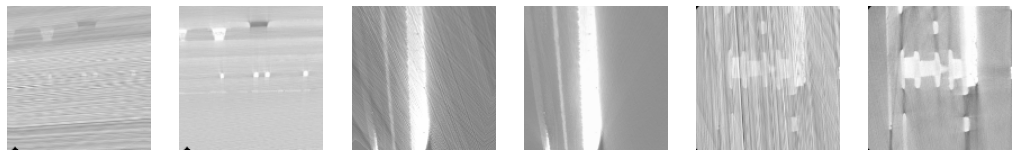

In [17]:
accum = 2
dls = dblock.dataloaders(crp_lat, bs=64//accum)
dls.c = 3
cbs = GradientAccumulation(64) if accum else []
#cbs += [LossMetrics]
dls.show_batch(nrows=1, ncols=3)

### Define the U-Net

In [18]:
wd = 1e-3
y_range = (0, 1)
learn = unet_learner(dls, 
                     resnet50, 
                     pretrained=True,
                     wd=wd, 
                     loss_func=feat_loss, 
                     blur=True,
                     self_attention=True,
                     #norm_type=NormType.Weight,
                     metrics=[mse, mae],
                     #y_range=y_range,
                     #n_in=1,
                     #n_out=1,
                     cbs=cbs,
                    ).to_fp16()

/home/juan/mambaforge/envs/fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/juan/mambaforge/envs/fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Find the right learning rate

Here we use FastAI's lr_find function to sweep through a large range of learning rates and suggest a number we can use that will gives us the maximum training without falling into instabilities.

SuggestedLRs(minimum=8.912509656511247e-05, valley=4.46683588961605e-05)

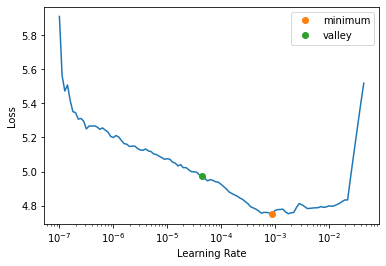

In [19]:
learn.lr_find(suggest_funcs=[minimum, valley], end_lr=1000, num_it=200)

Since we're using a `ResNet50` model for this training and this is a vision application, the model should only require some training in the last layers. The `fine_tune` method allows for the selective unfreeze of some of the last layers and their training using a strict 1-cycle policy.

In [20]:
learn.fine_tune(15, base_lr=1e-3, freeze_epochs=3)

epoch,train_loss,valid_loss,mse,mae,time
0,3.759645,3.519774,2.185659,0.867720,10:34
1,3.443246,3.313853,2.086179,0.854942,09:53
2,3.157463,2.609716,0.801668,0.548045,10:40


epoch,train_loss,valid_loss,mse,mae,time
0,2.263152,1.917143,0.201451,0.295161,09:23
1,2.090922,1.826157,0.168077,0.275554,09:20
2,2.030793,1.750588,0.153102,0.273752,09:38
3,1.967477,1.660006,0.128135,0.245803,09:44
4,1.874559,1.597451,0.108408,0.228342,08:34
5,1.806963,1.564758,0.130832,0.245610,08:45
6,1.736484,1.528925,0.102298,0.224343,09:05
7,1.641481,1.414897,0.081543,0.196214,10:07
8,1.601218,1.472612,0.106439,0.232146,08:38
9,1.554331,1.392800,0.083453,0.208086,09:09


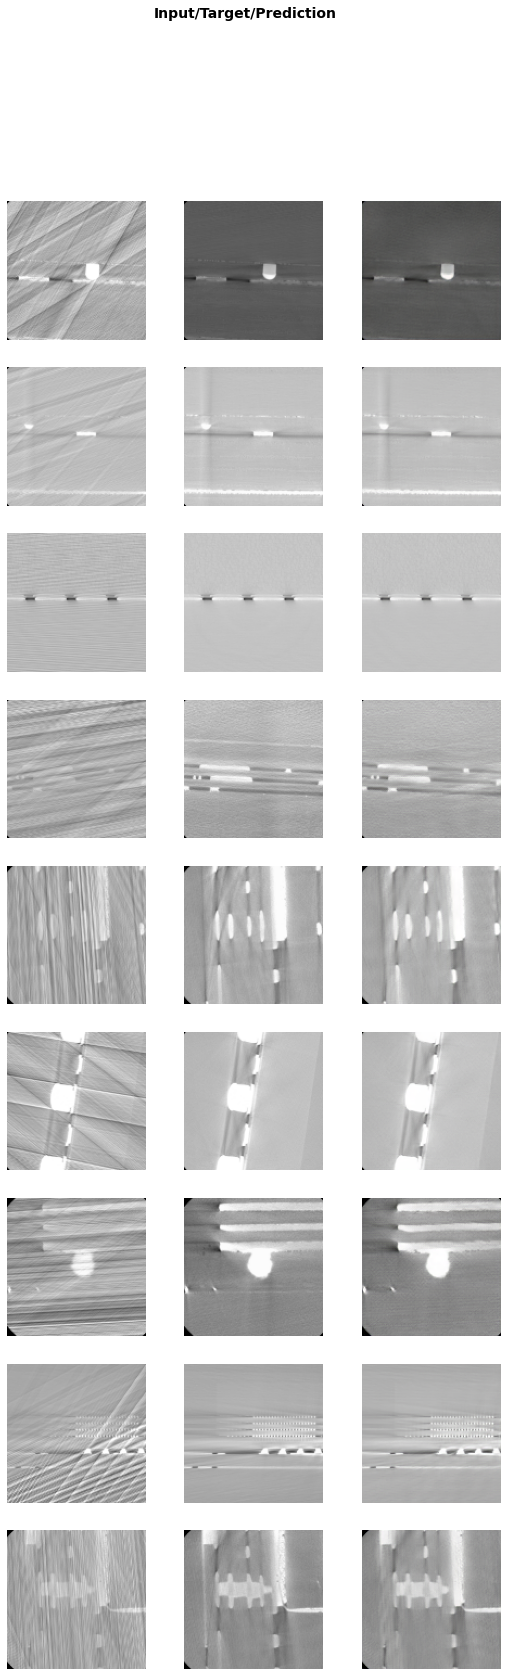

In [21]:
learn.show_results()

In [22]:
learn.export(path/'20220825_R50_FL_128.pkl')

### Let's increase the image size

In order to show capability, we use now a larger crop area for a next-level training of the model. We only need to train a few epochs because the initial hard work was done already with the smaller images.

In [17]:
learn = load_learner(path/'20220825_R50_FL_128.pkl')

In [18]:
item = Resize(448, method=ResizeMethod.Crop)
batch = [*aug_transforms(flip_vert=True, size=224, max_rotate=45.0, min_scale=0.75), Normalize()]

dblock = DataBlock(
        blocks=(ImageBlock(PILImage), ImageBlock(PILImage)),
        n_inp=1,
        get_items=get_image_files,
        get_y=get_y,
        splitter=RandomSplitter(valid_pct=0.2),
        item_tfms=item,
        batch_tfms=batch,
)

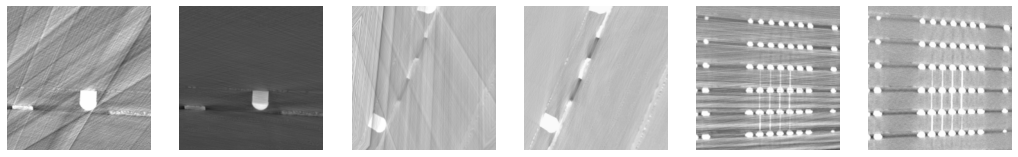

In [19]:
accum = 6
dls = dblock.dataloaders(crp_lat, bs=64//accum)
dls.c = 3
cbs = GradientAccumulation(64) if accum else []
#cbs += [LossMetrics]
dls.show_batch(nrows=1, ncols=3)

In [20]:
learn.dls = dls

SuggestedLRs(minimum=6.025595939718187e-05, valley=0.0001273503148695454)

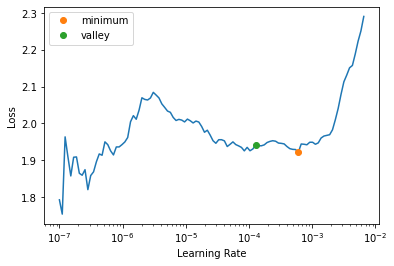

In [21]:
learn.lr_find(suggest_funcs=[minimum, valley], end_lr=100, num_it=200)

In [22]:
learn.fine_tune(5, base_lr=1e-4, freeze_epochs=3)

epoch,train_loss,valid_loss,mse,mae,time
0,1.773946,1.155278,0.143961,0.251217,43:00
1,1.538201,1.135846,0.133280,0.249941,42:34
2,1.444152,1.109244,0.128856,0.245226,41:31


epoch,train_loss,valid_loss,mse,mae,time
0,1.402206,1.059702,0.111691,0.224015,41:08
1,1.399087,1.073283,0.117763,0.233251,41:00
2,1.362644,1.052603,0.109496,0.224790,40:31
3,1.330981,1.034533,0.110966,0.219356,40:30
4,1.301652,1.040552,0.110498,0.221629,40:30


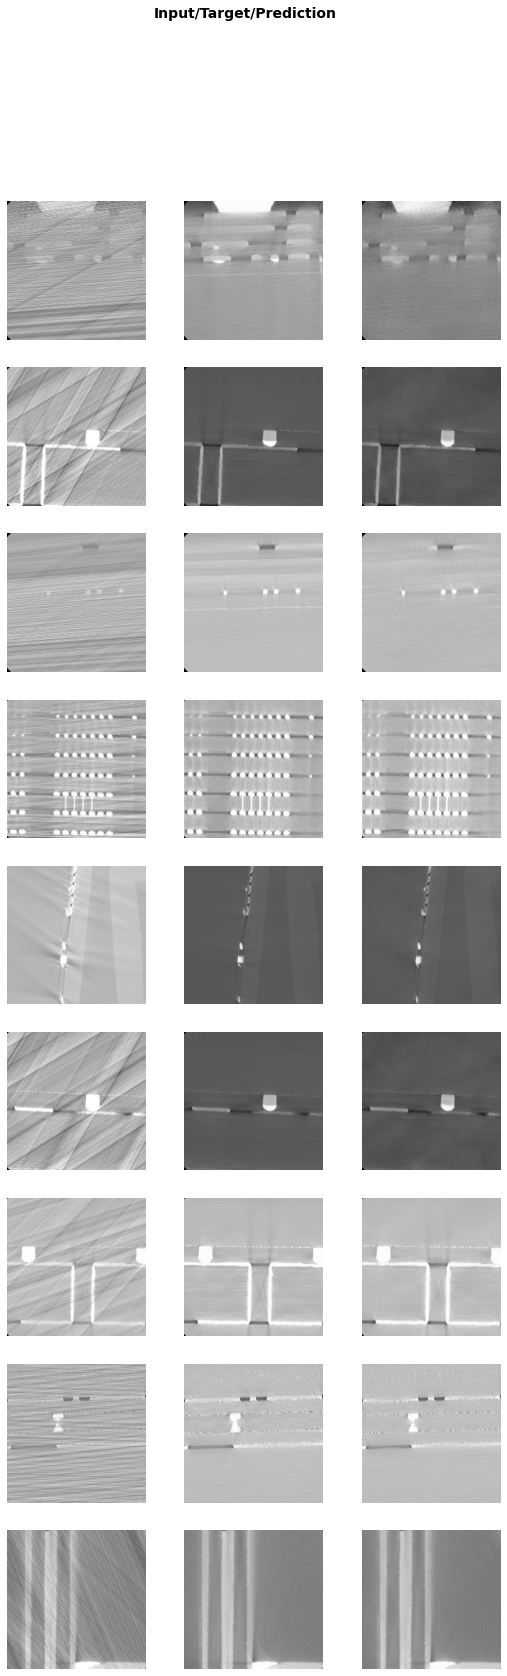

In [23]:
learn.show_results()

In [25]:
learn.export(path/'20220825_R50_FL_224.pkl')